<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook4_Physics_%3EVAE_con_VAE_Huey's_PFMData_WindowSize30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:

March, 2022

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- Pyroved developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- PFM data from [Bryan D Huey](https://scholar.google.com/citations?user=w2lbUCIAAAAJ&hl=en)
- Analyses of PFM data by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

Package Version:

*   atomai: 0.7.3
*   numpy: 1.21.5
*   torch: 1.8.1+cu102
*   scipy: 1.4.1
*   cv2: 4.1.2
*   skimage: 0.18.3

# **Install**

In [1]:
!pip install atomai
!pip install git+https://github.com/ziatdinovmax/pyroved
!pip install -q pyroved kornia
!pip install -U gdown

     |████████████████████████████████| 146 kB 33.7 MB/s 
     |████████████████████████████████| 310 kB 68.2 MB/s 
     |████████████████████████████████| 193 kB 11.2 MB/s 
     |████████████████████████████████| 865 kB 23.3 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=2d8a79e14b5f5ea7c74abac68a818fc0d9b5d05e34cb1ac4f859a3731ce61395
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=953f181374df372abe5ed3b3ce42df057de30f476527c7d19cde13546120b20f
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built gpytorch mendeleev
  Cloning https://github.com/ziatdinovmax/pyroved to /tmp/pip-req-build-2pulfr1o
  Running command git clone -q https://github.com/ziatdinovmax/pyroved /tmp/pip-req-build-2pulfr1o
     |██████████

# **Imports**

In [2]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.filters import gaussian_filter
from skimage import feature
from atomai import utils

In [3]:
# Download Data
#!gdown https://drive.google.com/uc?id=1fn9-GhIXnVoXNSL4kxSI_S1Q4GqWORTO
!gdown https://drive.google.com/uc?id=134fUHC6ekOpq4gLdVjzUnHbi1mM6kV9i

filename = '/content/s-Growth-RsinThmask-56.0449to56.0449-8bit (1).tif'
#filename = "/content/s-Nuc-RsinThmask-56.2761to56.2761-8bit (1).tif"

Downloading...
From: https://drive.google.com/uc?id=134fUHC6ekOpq4gLdVjzUnHbi1mM6kV9i
To: /content/s-Growth-RsinThmask-56.0449to56.0449-8bit (1).tif
100% 3.36M/3.36M [00:00<00:00, 260MB/s]


In [4]:
imgdata = cv2.imreadmulti(filename)
imgdata = np.array(imgdata[1])
imgdata = imgdata [16:53, 25:, :]

In [5]:
#deonise phase images first
imgdata_g = gaussian_filter(imgdata, sigma = 2)   

#predict 180 walls in phase images by Canny filter 
img_wall = np.zeros_like(imgdata_g) #initializ an array for saving 180 wall images
for i in range (len(imgdata)):
    img_wall[i,...] = feature.canny(imgdata[i,...], sigma=4.5);

(-0.5, 246.5, 200.5, -0.5)

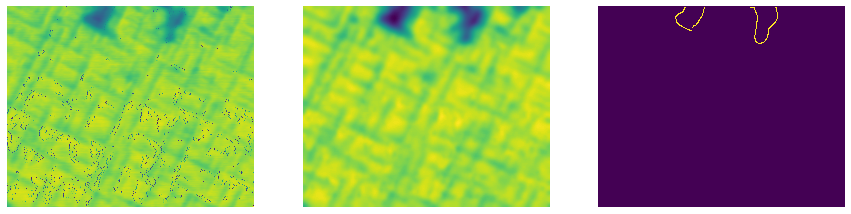

In [6]:
k = -1

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(imgdata[k])
ax1.axis('off')
ax2.imshow(imgdata_g[k])
ax2.axis("off")
ax3.imshow(img_wall[k])
ax3.axis("off")

(-0.5, 246.5, 200.5, -0.5)

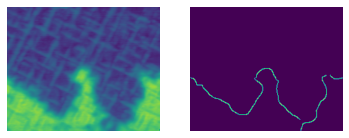

In [7]:
#initialize array for saving phase and 180 wall images
wallimg = np.array(img_wall, dtype = np.float64)
rawimg = np.array(imgdata, dtype = np.float64)

#Normalize phase and 180 wall images
for i in range (len(imgdata)):
  wallimg[i,...] = (wallimg[i,...]-wallimg[i,...].min())/(wallimg[i,...].max()-wallimg[i,...].min())
  rawimg[i,...] = (rawimg[i,...]-rawimg[i,...].min())/(rawimg[i,...].max()-rawimg[i,...].min())

k = 5
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(rawimg[k])
ax1.axis('off')
ax2.imshow(wallimg[k])
ax2.axis("off")

In [8]:
#make wall coordinates for 37 images to set as center later
wall_cor = ()

for i in range (len(imgdata)):
  index = np.where(wallimg[i,...]!=0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

dictionary = {}
for j in range (len(imgdata)):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*2,])):
    d = np.append(d,[[cor[j*2][i]], [cor[j*2+1][i]], [0]], axis =1)
  d=d.T
  #control coordinates size to 80
  nu = int(3000/(len(rawimg)))
  A = np.arange(len(d))
  idx = np.random.choice(A, nu, replace = False)
  B = d[idx,]
  dictionary [j] = np.array(B)

coordinates = dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


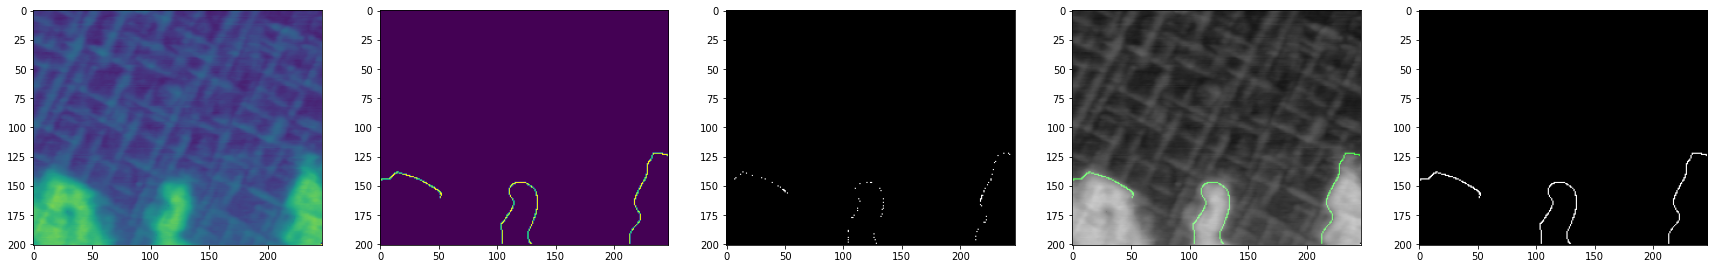

In [9]:
#test wall
j = 1
c = coordinates [j]

tem = np.zeros((201,247))

for i in range (80):
  a1 = c[i,0]; a2 = c[i,1]
  tem[a1,a2] = 1

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (30,8))
ax1.imshow(rawimg[j,...])
ax2.imshow(wallimg[j,...])
ax3.imshow(tem, cmap = 'gray')
ax4.imshow(np.dstack((rawimg[j,...], rawimg[j,...]+wallimg[j,...], rawimg[j,...])), cmap='gray')
ax5.imshow(np.dstack((wallimg[j,...], wallimg[j,...]+tem, wallimg[j,...])), cmap='gray')

Define a function to generate data with delay time

In [10]:
def t_delay (dt):
  global rawimg
  global wallimg
  rawimg_t = np.zeros_like(rawimg[dt:,...])
  wallimg_t = np.zeros_like(wallimg[dt:,...])
  for i in range (int(len(rawimg)-dt)):
    rawimg_t[i]=rawimg[i+dt]
    wallimg_t[i]=wallimg[i]
  wall_cor = ()

  for i in range (int(len(rawimg)-dt)):
    index = np.where(wallimg_t[i,...]!=0)
    wall_cor = wall_cor+index
  
  cor = np.array(wall_cor)

  dictionary = {}
  for j in range (int(len(rawimg)-dt)):
    d = np.array([[0],[0],[0]])
    for i in range (len(cor[j*2,])):
      d = np.append(d,[[cor[j*2][i]], [cor[j*2+1][i]], [0]], axis =1)
    d=d.T
  #control coordinates size to num
    num = int(3000/(len(rawimg)-dt))   # roughly keep total number ~1000
    A = np.arange(len(d))
    idx = np.random.choice(A, num, replace = False)
    B = d[idx,]
    dictionary [j] = np.array(B)
  
  coordinates_t = dictionary
  return rawimg_t, wallimg_t, coordinates_t

Generate data with delay time

In [11]:
r_1, w_1, c_1 = t_delay(dt = 1)
r_2, w_2, c_2 = t_delay(dt = 2)
r_3, w_3, c_3 = t_delay(dt = 3)
r_4, w_4, c_4 = t_delay(dt = 4)
r_5, w_5, c_5 = t_delay(dt = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [12]:
import copy

def update_ (ri, co, dt):
  global coors
  global rawimg0
  global rawimg
  #update coordinates first
  coor = copy.deepcopy(co)
  l = len(rawimg)
  postpone = np.linspace(l, l-dt+1, dt, dtype = int).sum()
  for i in range (int(l-dt)):
    coor[i+postpone] = co[i]
    del coor[i]
  coors.update(coor)

  #update image then
  rawimg0 = np.append(rawimg0, ri, axis = 0)

In [13]:
rawimg0 = np.copy(rawimg)   #images
coors = copy.deepcopy(coordinates)  #coordinates

update_(ri = r_1, co = c_1, dt = 1)
update_(ri = r_2, co = c_2, dt = 2)
update_(ri = r_3, co = c_3, dt = 3)
update_(ri = r_4, co = c_4, dt = 4)
update_(ri = r_5, co = c_5, dt = 5)

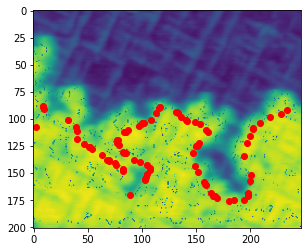

In [14]:
k = 150
plt.imshow(rawimg0[k])
plt.scatter(coors[k][:,1,], coors[k][:,0,], c = 'r')

Make image patches for training

In [15]:
ws=30
imstack0, com, frames = utils.extract_subimages(rawimg0, coors, ws)

(14542, 30, 30)

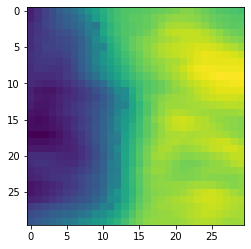

In [16]:
plt.imshow(imstack0[5000])
imstack0.shape

In [17]:
#update ground truth time delay
delta_t0 = np.empty(0)

arr = np.arange(6)
for k in arr:
    for i in range(int(len(rawimg)-k)):
       postpone = np.linspace(len(rawimg), len(rawimg)-k+1, k, dtype = int).sum()
       t = np.zeros(len(imstack0 [frames == i+postpone])) + k
       delta_t0 = np.append(delta_t0, t) 

In [18]:
#make ground truth switch degree
ther = np.mean(imstack0.reshape(-1))
switch_deg0 = np.zeros(len(imstack0))

for i in range (len(imstack0)):
  subimg = imstack0[i]

  p_switch = (subimg>ther).sum()
  n_switch = (subimg<ther).sum()

  switch_deg0 [i] = (n_switch-p_switch)/(n_switch+p_switch)

In [19]:
imstack = np.zeros_like(imstack0)
delta_t = np.zeros_like(delta_t0)
switch_deg = np.zeros_like(switch_deg0)

inx = np.arange(len(imstack))
np.random.shuffle(inx)

for i in range (len(imstack)):
  imstack[i,] = imstack0[inx[i]]
  delta_t[i]  = delta_t0[inx[i]]
  switch_deg[i] = switch_deg0[inx[i]]

Load data into the notebook and transform to a proper format:

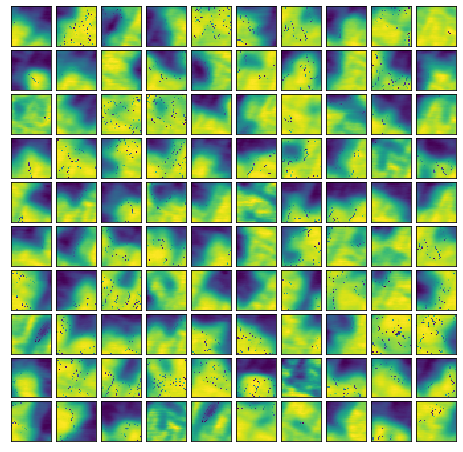

In [20]:
np.random.seed(1)
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i], interpolation='nearest')

Prepare training data and ground truth

In [21]:
train_data = torch.from_numpy(np.float32(imstack))
t_delay = torch.from_numpy(np.float32(delta_t.reshape(-1,1)))
deg_switch = torch.from_numpy(np.float32(switch_deg)).unsqueeze(1)

In [22]:
#training steps
steps = 200
inv = None  # include roatational or not, if yes, set as 'r'; if no, set as None

Let first perform simple VAE analysis

In [23]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

in_dim = (ws, ws)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae0 = pv.models.iVAE(in_dim, latent_dim=2, invariances = inv, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 535.8040
Epoch: 2 Training loss: 521.9956
Epoch: 3 Training loss: 521.2030
Epoch: 4 Training loss: 520.5538
Epoch: 5 Training loss: 520.5500
Epoch: 6 Training loss: 520.1585
Epoch: 7 Training loss: 520.0429
Epoch: 8 Training loss: 520.1136
Epoch: 9 Training loss: 520.0024
Epoch: 10 Training loss: 520.0269
Epoch: 11 Training loss: 519.8732
Epoch: 12 Training loss: 519.9366
Epoch: 13 Training loss: 520.0625
Epoch: 14 Training loss: 519.7421
Epoch: 15 Training loss: 519.7878
Epoch: 16 Training loss: 519.7241
Epoch: 17 Training loss: 519.5184
Epoch: 18 Training loss: 519.4934
Epoch: 19 Training loss: 519.5696
Epoch: 20 Training loss: 519.5290
Epoch: 21 Training loss: 519.4888
Epoch: 22 Training loss: 519.4632
Epoch: 23 Training loss: 519.4245
Epoch: 24 Training loss: 519.3812
Epoch: 25 Training loss: 519.4228
Epoch: 26 Training loss: 519.3500
Epoch: 27 Training loss: 519.2663
Epoch: 28 Training loss: 519.4505
Epoch: 29 Training loss: 519.2084
Epoch: 30 Training loss

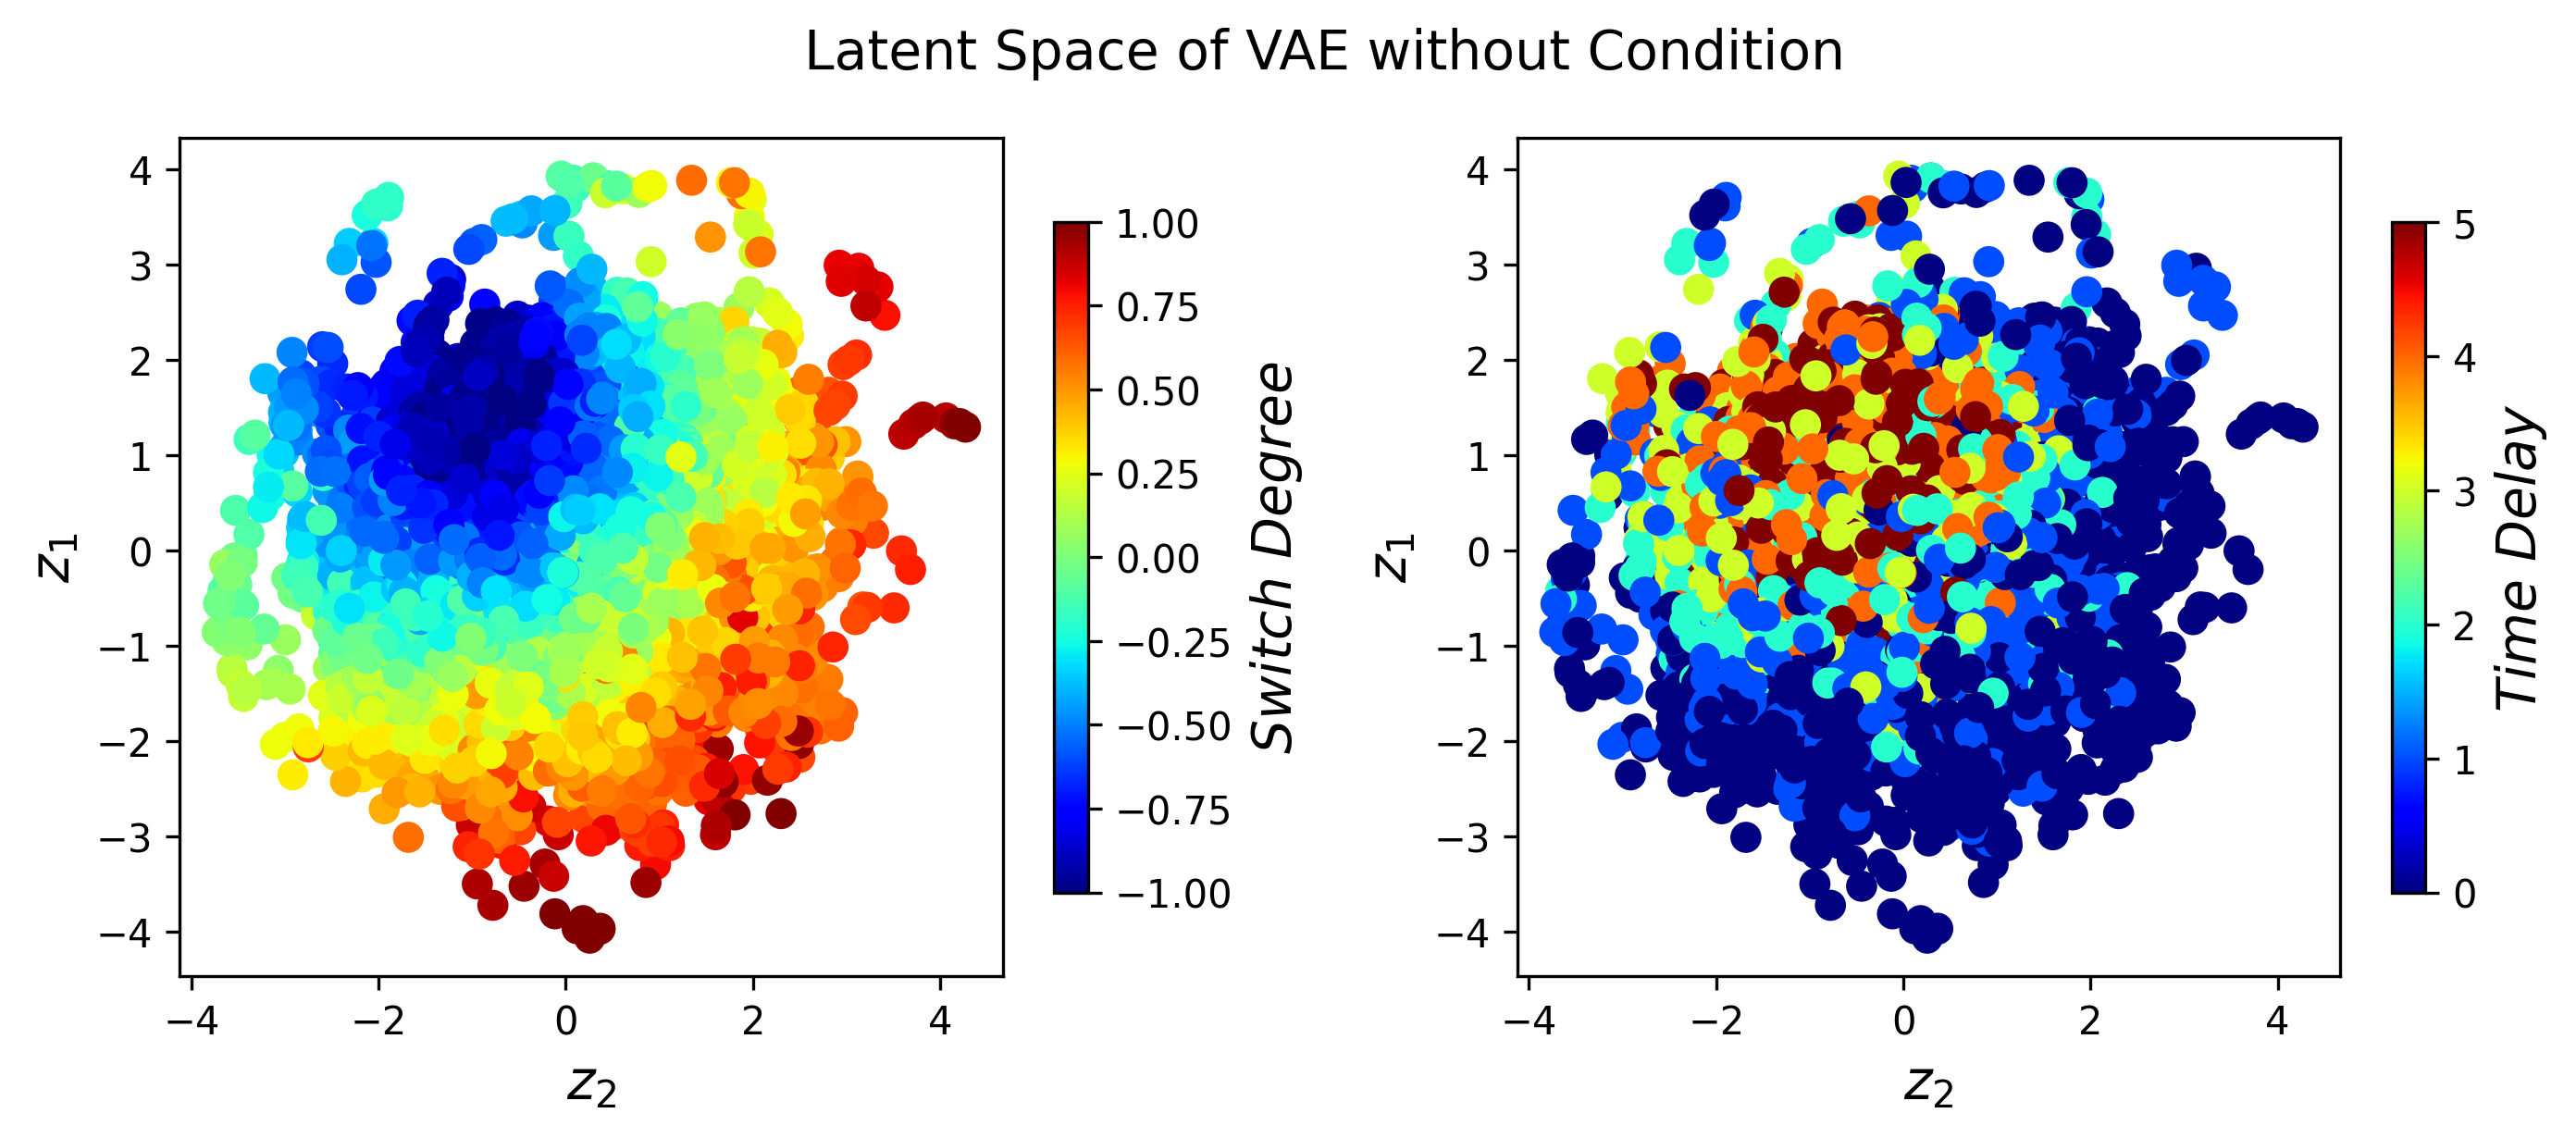

In [24]:
z_mean, z_sd = vae0.encode(train_data)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Space of VAE without Condition', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = deg_switch, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label('$Switch$' +' '+'$Degree$', fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = t_delay, cmap = 'jet' )
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label('$Time$' +' '+'$ Delay$', fontsize=14)

Plot latent variable vs. ground truth

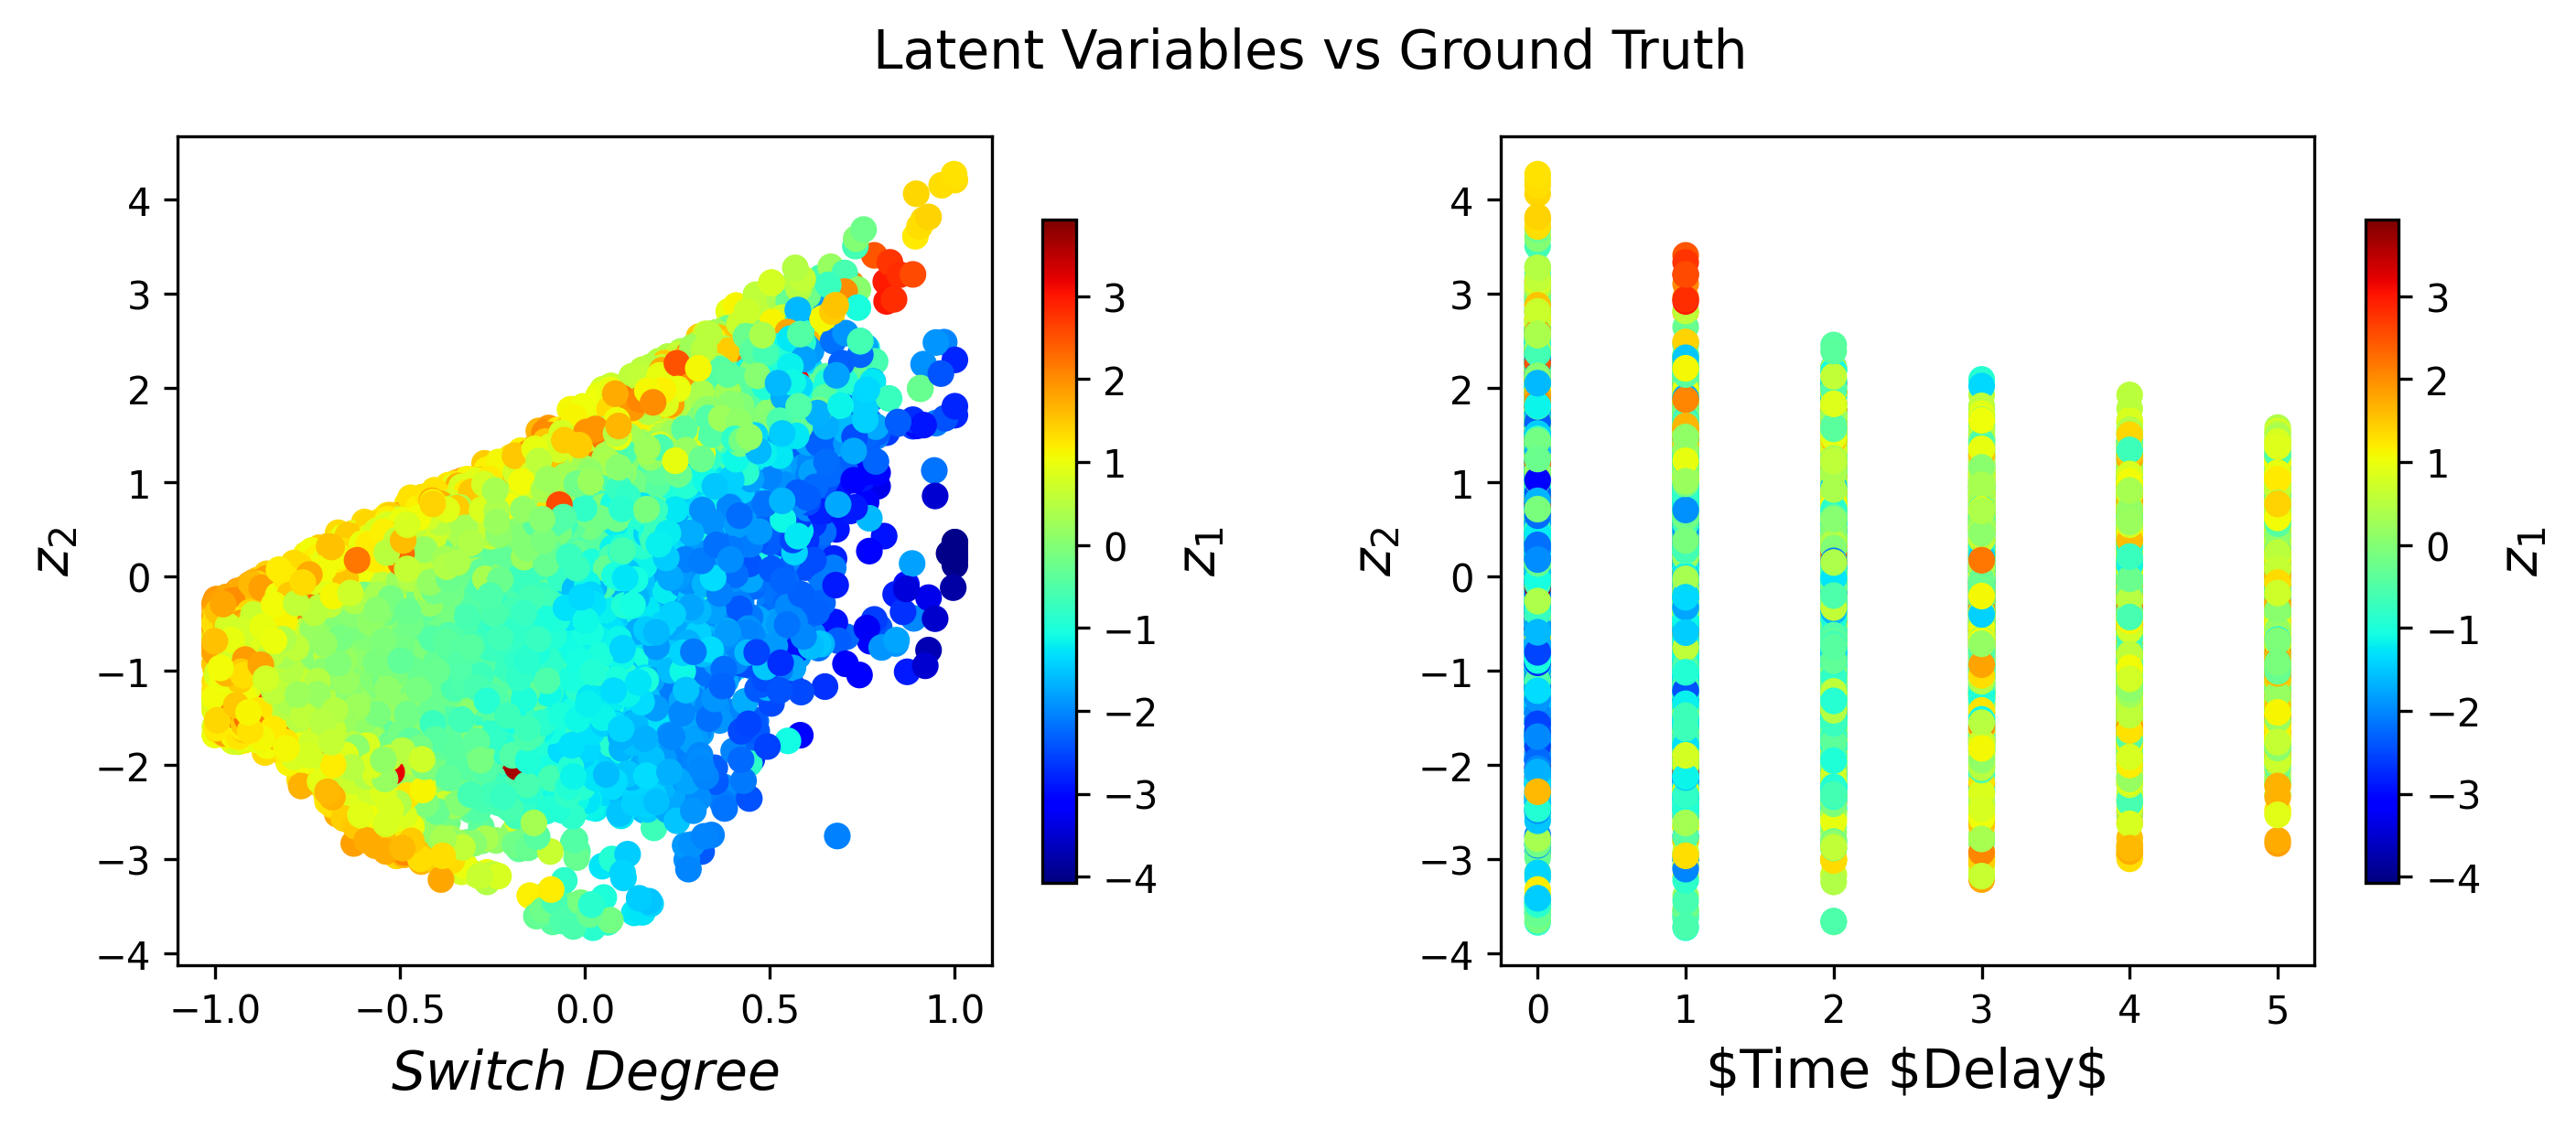

In [25]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Variables vs Ground Truth', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(deg_switch, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet') 
ax1.set_xlabel('$Switch$'+' '+'$Degree$', fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=14)

im3 = ax3.scatter(t_delay, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet')
ax3.set_xlabel('$Time'+' '+'$Delay$', fontsize=14)
ax3.set_ylabel("$z_2$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$z_1$", fontsize=14)

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about time delay as our $c$ vector.

In [26]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), t_delay, batch_size=64)

in_dim = (ws, ws)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances = inv, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 537.0672
Epoch: 2 Training loss: 522.1444
Epoch: 3 Training loss: 520.7192
Epoch: 4 Training loss: 520.4005
Epoch: 5 Training loss: 520.0341
Epoch: 6 Training loss: 519.7868
Epoch: 7 Training loss: 519.7732
Epoch: 8 Training loss: 519.4948
Epoch: 9 Training loss: 519.4519
Epoch: 10 Training loss: 519.3693
Epoch: 11 Training loss: 519.3579
Epoch: 12 Training loss: 519.2218
Epoch: 13 Training loss: 519.1903
Epoch: 14 Training loss: 519.1257
Epoch: 15 Training loss: 519.0477
Epoch: 16 Training loss: 518.9649
Epoch: 17 Training loss: 519.0025
Epoch: 18 Training loss: 519.0575
Epoch: 19 Training loss: 518.9261
Epoch: 20 Training loss: 518.8188
Epoch: 21 Training loss: 518.8029
Epoch: 22 Training loss: 518.8432
Epoch: 23 Training loss: 518.8348
Epoch: 24 Training loss: 518.7790
Epoch: 25 Training loss: 518.7162
Epoch: 26 Training loss: 518.6703
Epoch: 27 Training loss: 518.6959
Epoch: 28 Training loss: 518.6757
Epoch: 29 Training loss: 518.5700
Epoch: 30 Training loss

Encode the training data into the latent space:

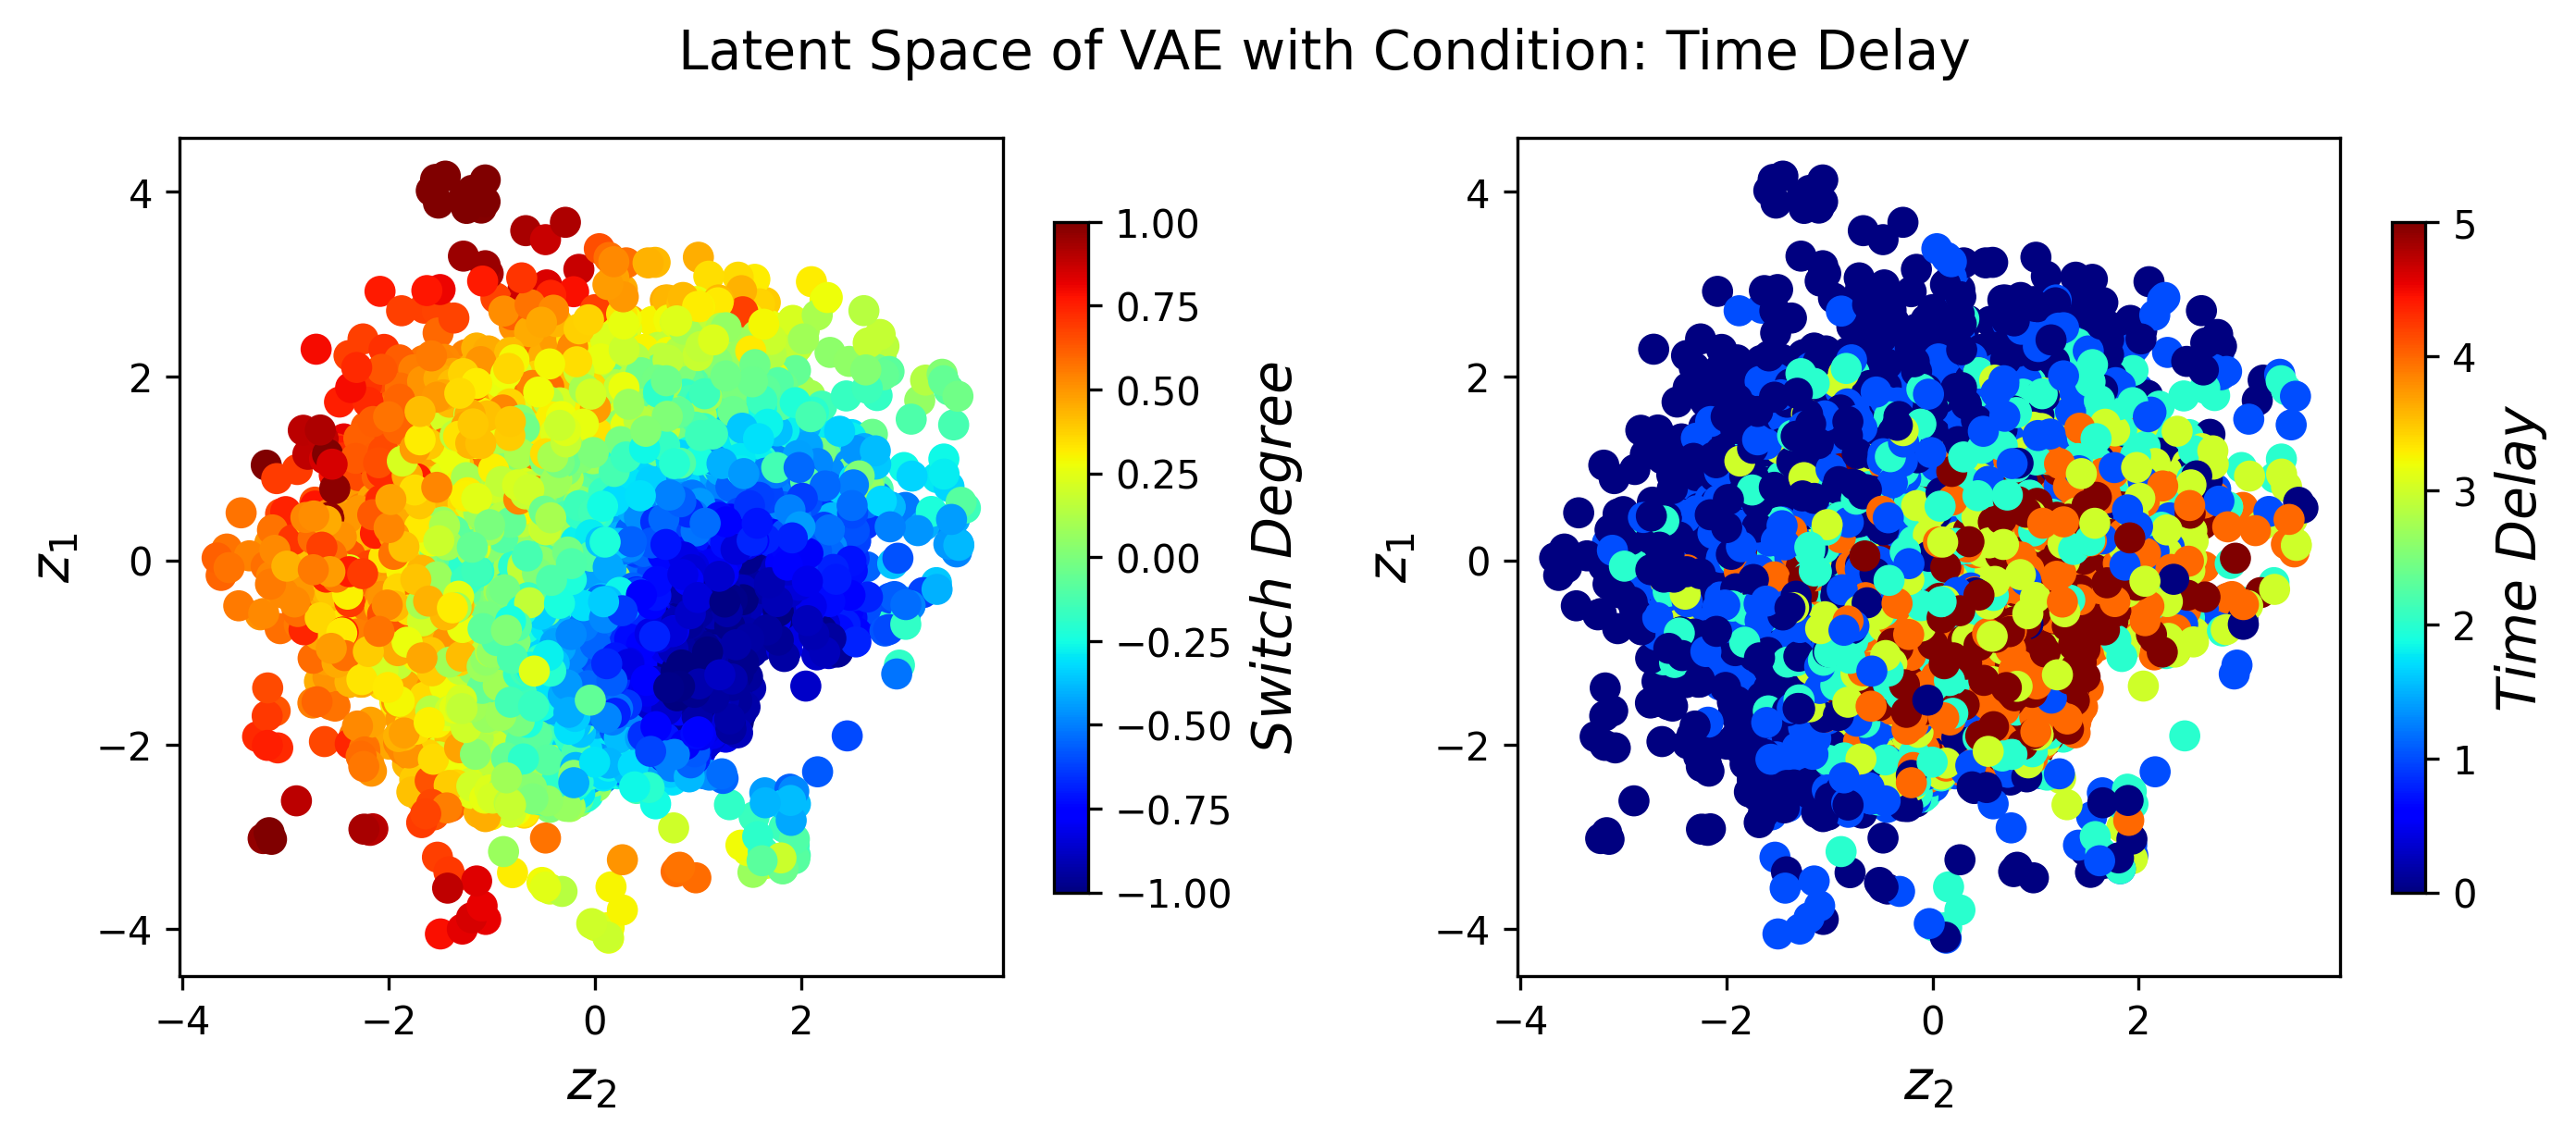

In [27]:
z_mean, z_sd = vae1.encode(train_data)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Space of VAE with Condition: Time Delay', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = deg_switch, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label('$Switch$' +' '+'$Degree$', fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = t_delay, cmap = 'jet' )
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label('$Time$' +' '+'$ Delay$', fontsize=14)

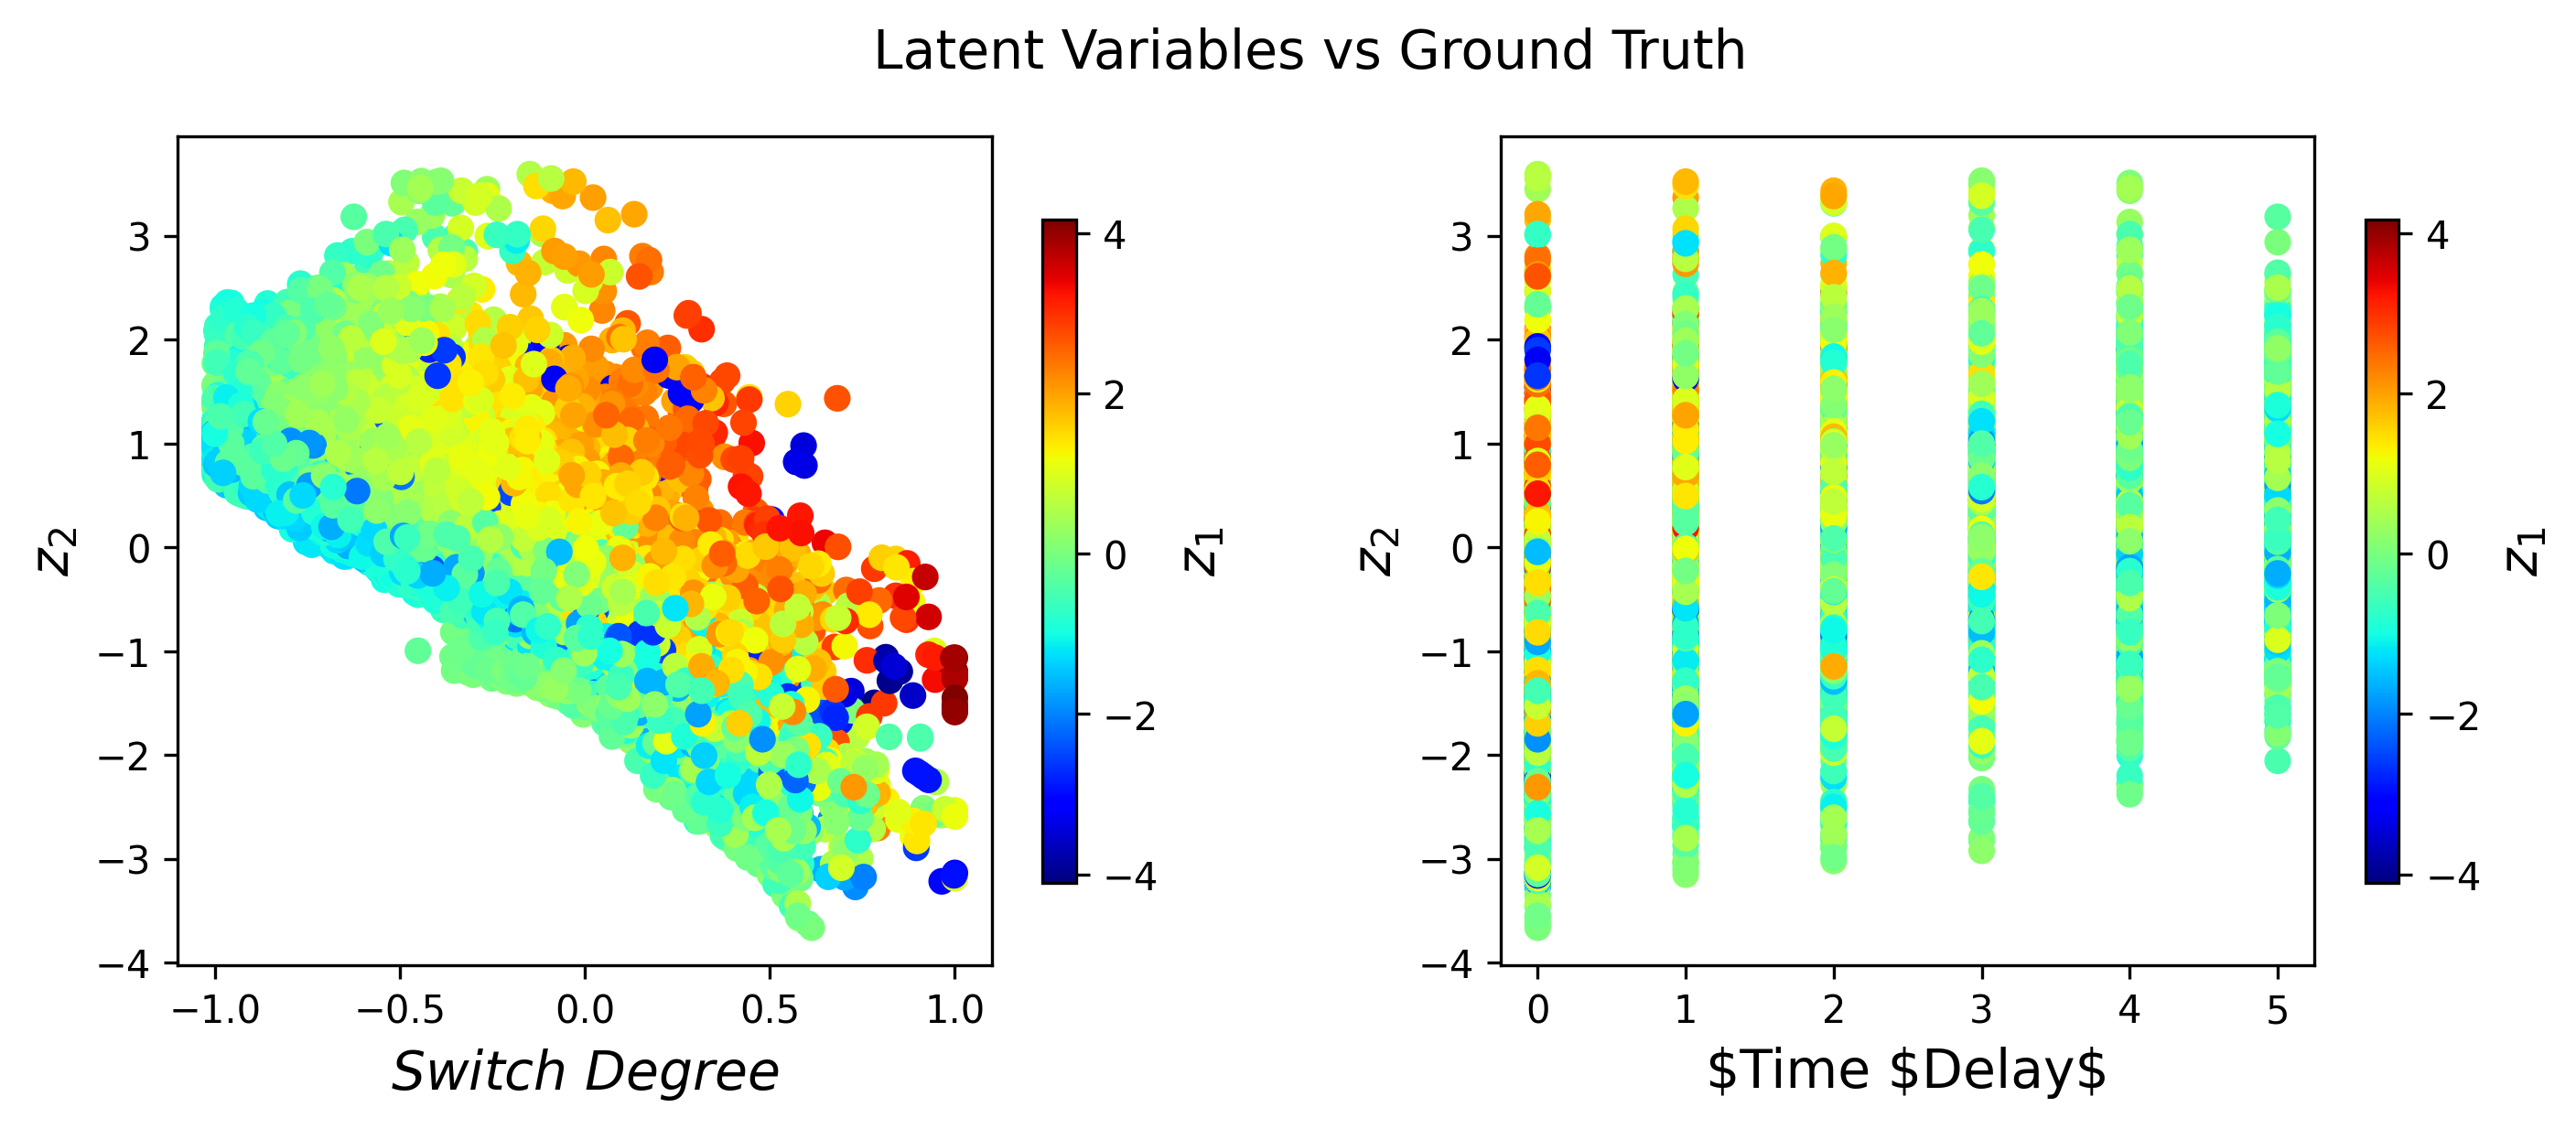

In [28]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Variables vs Ground Truth', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(deg_switch, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet') 
ax1.set_xlabel('$Switch$'+' '+'$Degree$', fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=14)

im3 = ax3.scatter(t_delay, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet')
ax3.set_xlabel('$Time'+' '+'$Delay$', fontsize=14)
ax3.set_ylabel("$z_2$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$z_1$", fontsize=14)

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about switch degree as our $c$ vector.

In [29]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), deg_switch, batch_size=64)

in_dim = (ws, ws)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae11 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances = inv, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae11)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 533.4743
Epoch: 2 Training loss: 518.7352
Epoch: 3 Training loss: 517.8838
Epoch: 4 Training loss: 517.1957
Epoch: 5 Training loss: 516.8416
Epoch: 6 Training loss: 516.5617
Epoch: 7 Training loss: 516.4080
Epoch: 8 Training loss: 516.2258
Epoch: 9 Training loss: 516.0982
Epoch: 10 Training loss: 516.0481
Epoch: 11 Training loss: 515.8872
Epoch: 12 Training loss: 515.8944
Epoch: 13 Training loss: 515.7792
Epoch: 14 Training loss: 515.7408
Epoch: 15 Training loss: 515.6600
Epoch: 16 Training loss: 515.7189
Epoch: 17 Training loss: 515.5466
Epoch: 18 Training loss: 515.5373
Epoch: 19 Training loss: 515.5560
Epoch: 20 Training loss: 515.4736
Epoch: 21 Training loss: 515.4268
Epoch: 22 Training loss: 515.4010
Epoch: 23 Training loss: 515.3943
Epoch: 24 Training loss: 515.3716
Epoch: 25 Training loss: 515.3292
Epoch: 26 Training loss: 515.3109
Epoch: 27 Training loss: 515.2726
Epoch: 28 Training loss: 515.2684
Epoch: 29 Training loss: 515.2140
Epoch: 30 Training loss

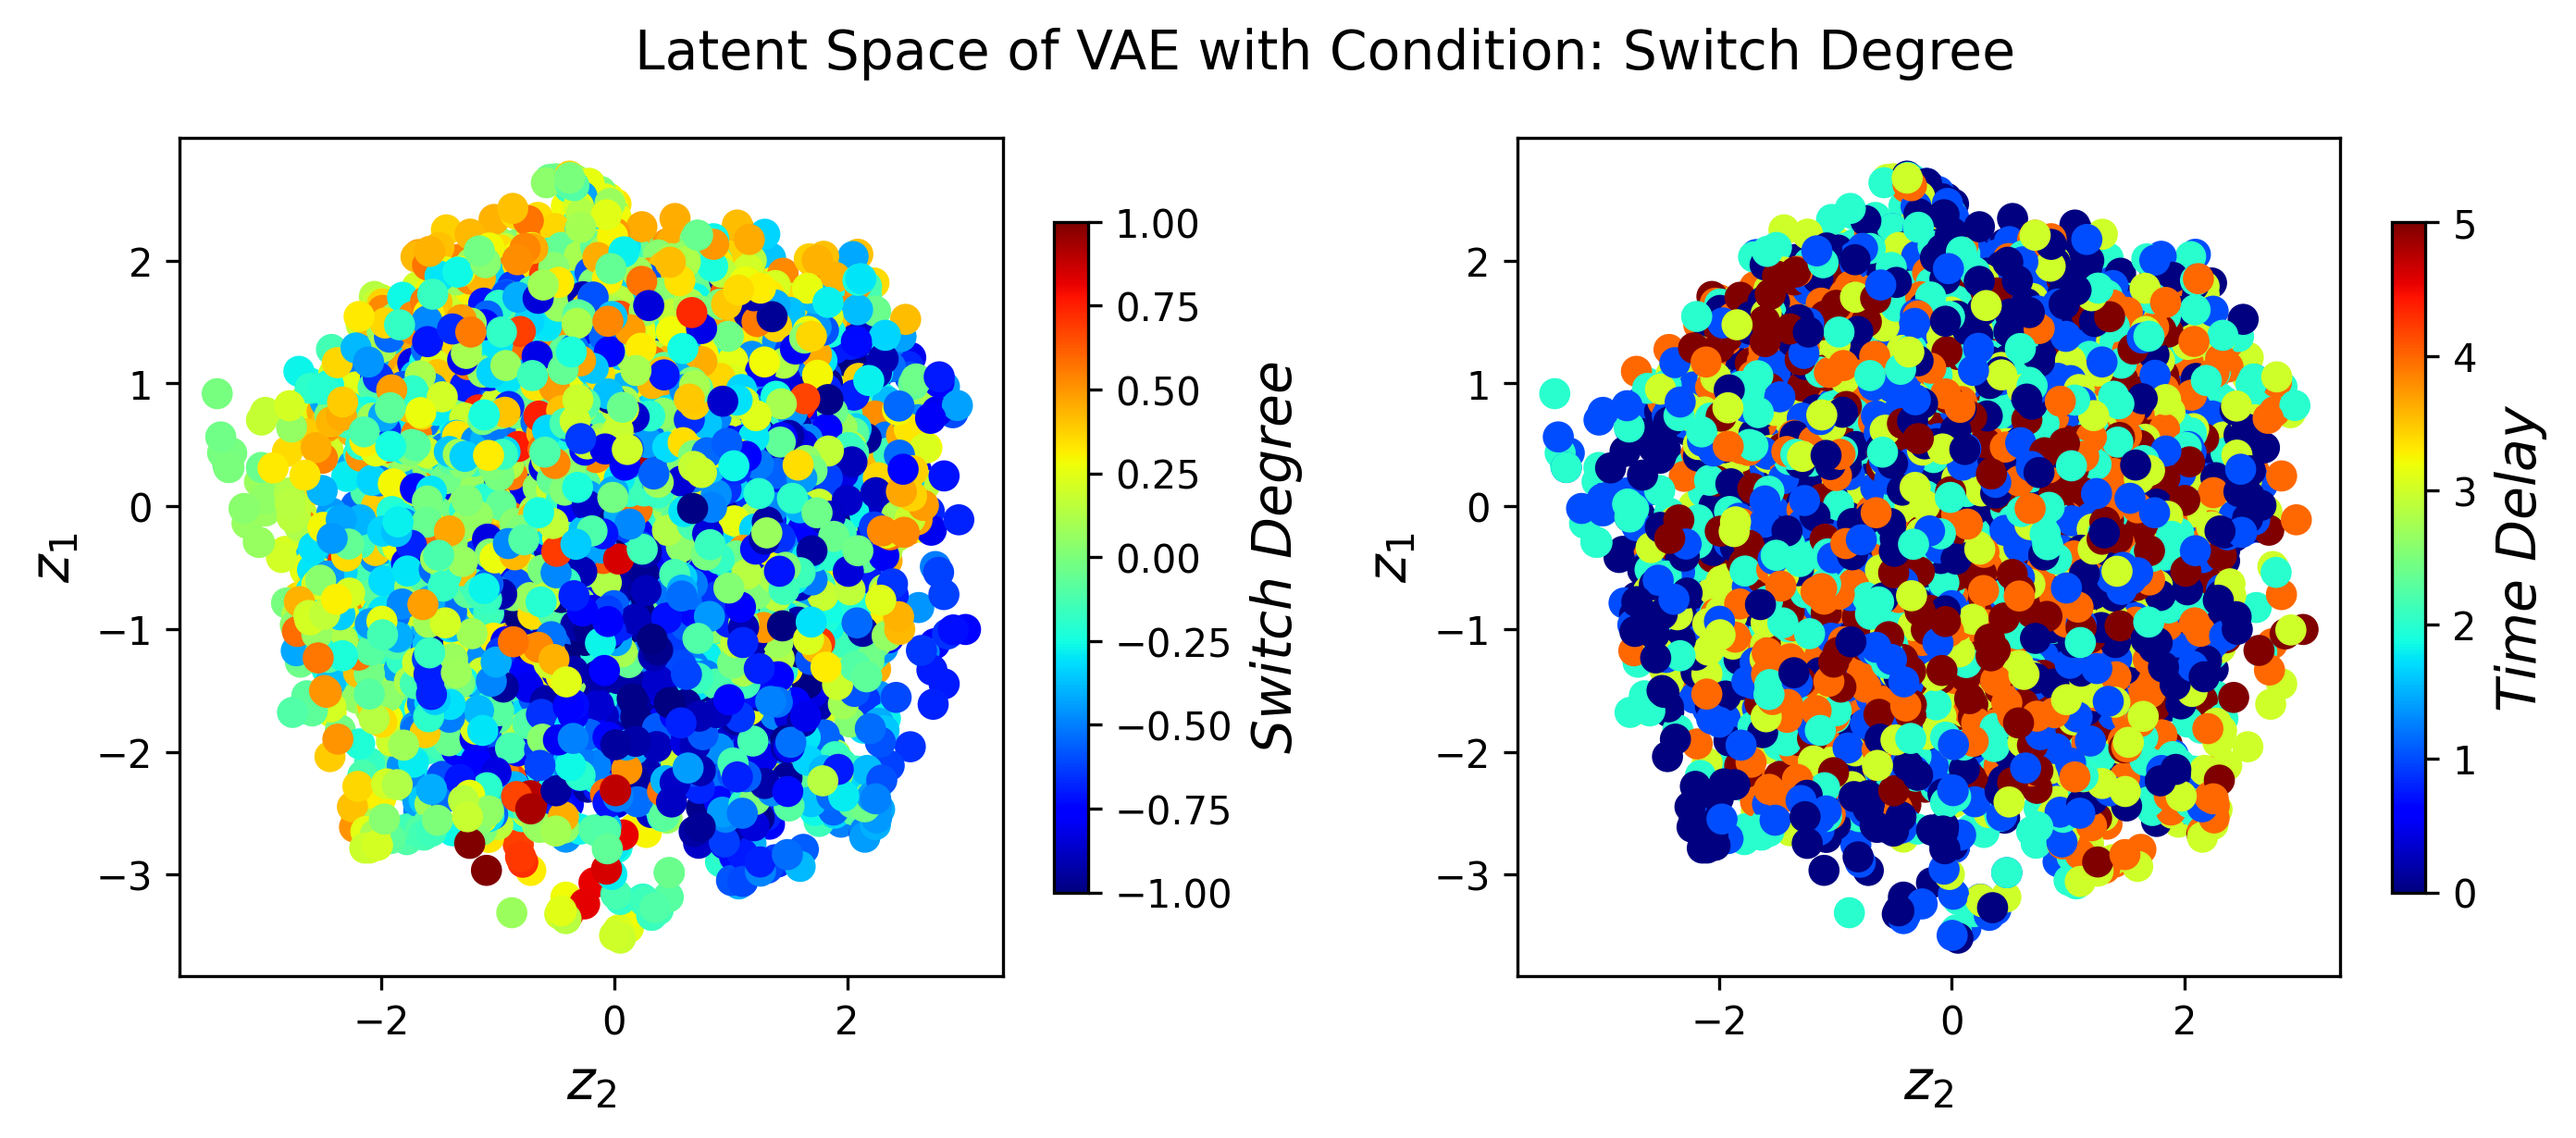

In [30]:
z_mean, z_sd = vae11.encode(train_data)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Space of VAE with Condition: Switch Degree', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = deg_switch, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label('$Switch$' +' '+'$Degree$', fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = t_delay, cmap = 'jet' )
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label('$Time$' +' '+'$ Delay$', fontsize=14)

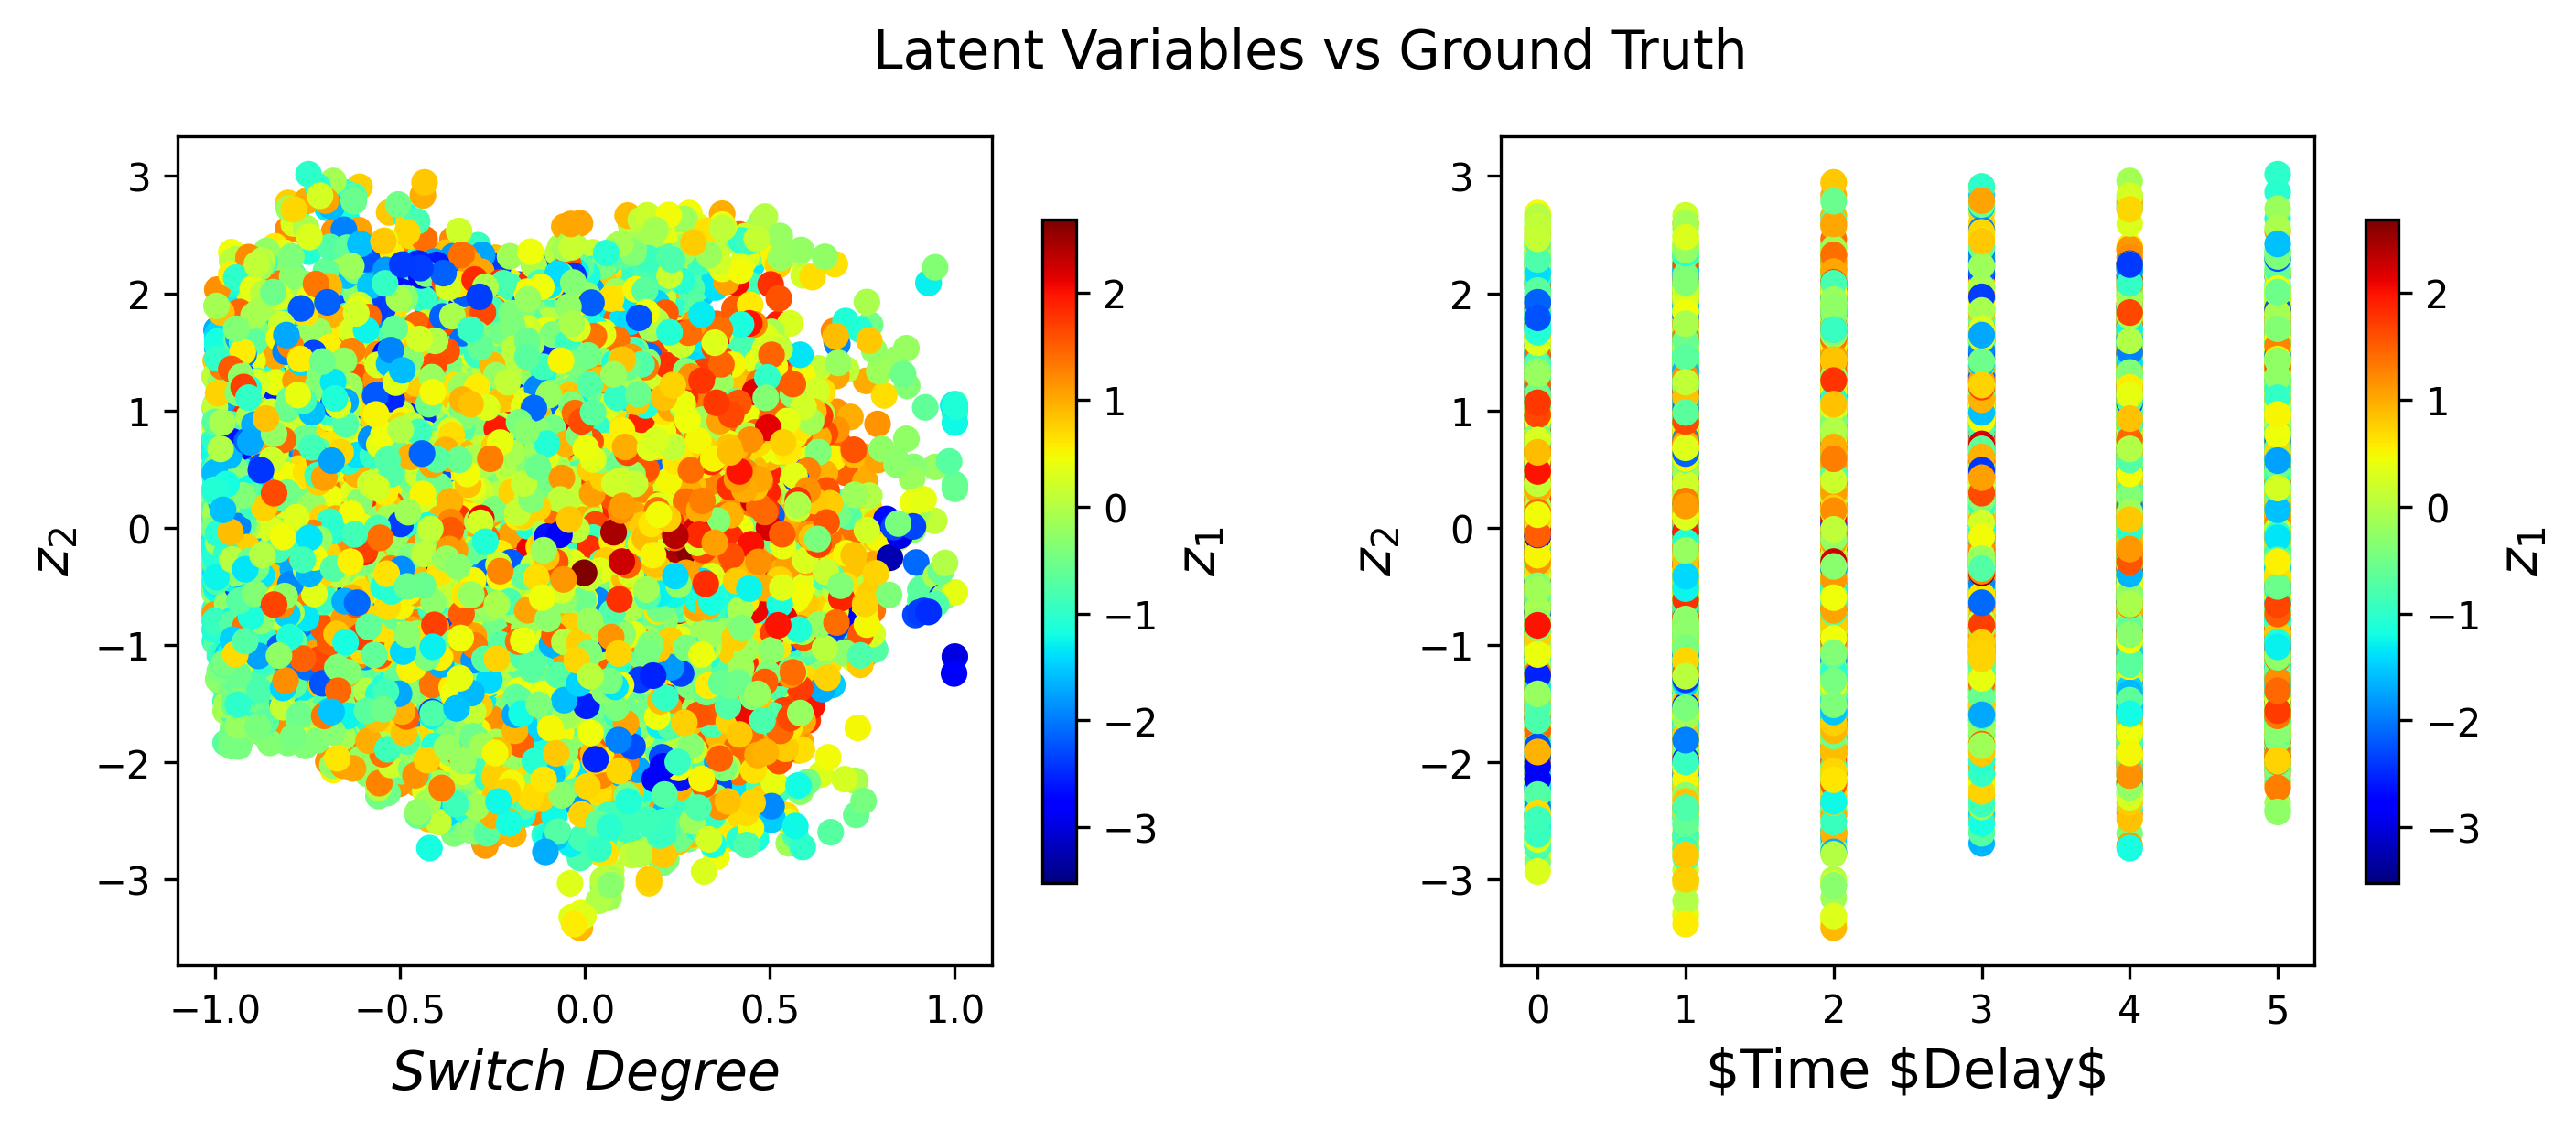

In [31]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(11, 4), dpi = 300)
fig.suptitle('Latent Variables vs Ground Truth', fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(deg_switch, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet') 
ax1.set_xlabel('$Switch$'+' '+'$Degree$', fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=14)

im3 = ax3.scatter(t_delay, z_mean[:, -1], c = z_mean[:, -2], cmap = 'jet')
ax3.set_xlabel('$Time'+' '+'$Delay$', fontsize=14)
ax3.set_ylabel("$z_2$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$z_1$", fontsize=14)